# Geohashを活用した建物IDの付番

Geohashを活用して建物に固有のIDを付与するプロジェクトのための作業ノートブック。

作成にあたっては [@sokimura39](https://github.com/sokimura39) さんの以下のノートブックをかなり参考にさせて頂きました。この場を借りてお礼申し上げます。
- [sokimura39/building_id_H3](https://github.com/sokimura39/building_id_H3)
  - [H3_grid_id.ipynb](https://github.com/sokimura39/building_id_H3/blob/main/H3_grid_id.ipynb)

### 使用データ

[3D都市モデル（Project PLATEAU）千代田区（2023年度）](https://www.geospatial.jp/ckan/dataset/plateau-13101-chiyoda-ku-2023) のCityGML（v3）データより、東京駅付近の3次メッシュ4区画分のLOD0データをGDALのogr2ogrでGeoPackageに変換したものを利用。
- 3次メッシュ: 53394600,53394601,53394610,53394611
- 平面直角座標系番号: 9系 (EPSG:6677)

### 使用した主なパッケージ

- geohash (python-geohash)
- GeoPandas

In [1]:
import geohash
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# 建物データをロード
gdf = gpd.read_file('../data/plateau/geopackage/13100_tokyo_2023.gpkg')

In [3]:
# 件数の確認。今回は4625の建物を対象とする。
print(f'対象建物数：{gdf.shape[0]}件')

対象建物数：4625件


#### ID付けを行う建物ポリゴン代表点の取得

In [4]:
# 後続のジオメトリ演算処理を正確に行うため、ポリゴンジオメトリを平面直角座標系に変換
gdf['projected_geometry'] = gdf['geometry'].to_crs('EPSG:6677')
# ポリゴンの重心を平面直角座標系で取得
gdf['projected_centroid'] = gdf['projected_geometry'].centroid

In [5]:
# 平面直角座標系で重心がポリゴン内に含まれるかを取得
gdf['is_centroid_inside'] = gdf["projected_geometry"].contains(gdf["projected_centroid"])

In [6]:
# 重心がポリゴン内に含まれない場合の件数を取得
outside_centroids = gdf[~gdf["is_centroid_inside"]]
print(f'重心がポリゴン内に含まれない件数:{len(outside_centroids)}')

重心がポリゴン内に含まれない件数:19


In [7]:
# 重心がポリゴン内に含まれない場合の対策として、ポリゴン内保証点(Point on Surface)を取得
gdf["projected_point_on_surface"] = gdf.apply(
    lambda row: row["projected_geometry"].point_on_surface(),
    axis=1
)

PLATEAUのbuilding_id: 13101-bldg-4528


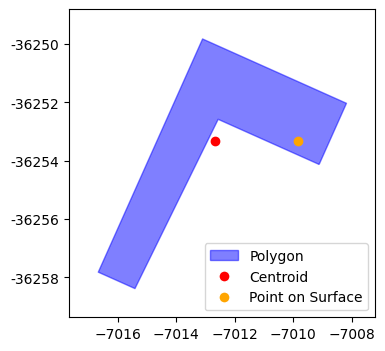

In [8]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# 重心がポリゴン内に含まれない場合の任意の行を取得
outside_centroids = gdf[~gdf["is_centroid_inside"]] # キーを追加したので再取得
example_row = outside_centroids.iloc[2]
# PLATEAUのbuilding_idを表示
print(f'PLATEAUのbuilding_id: {example_row["building_id"]}')

# プロット
fig, ax = plt.subplots(figsize=(4, 4))

# `example_row` のポリゴンと重心、ポリゴン内保証点のみをプロット
geom_series = gpd.GeoSeries(example_row["projected_geometry"])
geom_series.plot(ax=ax, color="blue", edgecolor="blue", alpha=0.5)

# 重心をプロット
centroid_x, centroid_y = example_row["projected_centroid"].coords[0]
ax.scatter(centroid_x, centroid_y, color="red", zorder=3, label="Centroid")

# ポリゴン内保証点をプロット
point_on_surface_x, point_on_surface_y = example_row["projected_point_on_surface"].coords[0]
ax.scatter(point_on_surface_x, point_on_surface_y, color="orange", zorder=4, label="Point on Surface")

# **プロット範囲の調整**
bounds = example_row["projected_geometry"].bounds  # (minx, miny, maxx, maxy)
padding = 1  # 少し余裕を持たせる
ax.set_xlim(bounds[0] - padding, bounds[2] + padding)
ax.set_ylim(bounds[1] - padding, bounds[3] + padding)

# **カスタム凡例を作成**
legend_elements = [
    Patch(facecolor='blue', edgecolor='blue', alpha=0.5, label='Polygon'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Centroid'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='Point on Surface')
]
ax.legend(handles=legend_elements, loc='lower right')

# **Y軸のラベルを通常表記に変更**
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.f"))

plt.show()

In [9]:
# 重心がポリゴン内に含まれない場合のフォールバック先として、ポリゴン内保証点を利用し、
# 代表点(Representative Point)として格納
gdf["projected_rep_point"] = gdf.apply(
    lambda row: row["projected_centroid"] if row["is_centroid_inside"] else row["projected_point_on_surface"],
    axis=1
)

In [10]:
# 代表点を経緯度座標に戻す
gdf['rep_point'] = gdf['projected_rep_point'].set_crs('EPSG:6677').to_crs('EPSG:4326')

#### 代表点にGeohashのID付与
[Geohashの桁数(精度)と矩形サイズの確認](check_geohash_size.ipynb) を参考に、代表点にGeohashの桁数11（1辺が10-15cm程度）のものを使用してID付け。

In [11]:
# IDを取得
# 桁数11: 1辺約10-15cmの矩形を使用し、中点が所在する矩形のIDをそのまま使用。
gdf['geohash'] = gdf['rep_point'].apply(
    lambda point: geohash.encode(point.y, point.x, 11)
)

In [12]:
# 結果を確認（最右列がGeohashID）
gdf[['geometry', 'rep_point', 'geohash']].head(5)

,geometry,rep_point,geohash
0,"MULTIPOLYGON (((139.75562 35.66728, 139.75572 ...",POINT (139.75568 35.66727),xn76ujnbzkb
1,"MULTIPOLYGON (((139.76152 35.66693, 139.7615 3...",POINT (139.76153 35.66692),xn76ukgnzdz
2,"MULTIPOLYGON (((139.75604 35.66746, 139.75606 ...",POINT (139.7559 35.6675),xn76ujp4hxe
3,"MULTIPOLYGON (((139.75876 35.66753, 139.75874 ...",POINT (139.75884 35.66748),xn76um1615g
4,"MULTIPOLYGON (((139.75313 35.66752, 139.75313 ...",POINT (139.7531 35.66746),xn76ujj450u


#### IDの有効性を確認

各IDが割り振られている数を確認し、重複がないことをチェックする。各IDは11桁の英数字となる。

In [13]:
# IDごとに重複が無いことを確認。
print(f"各IDに割り当てられた建物数の最大値：{gdf['geohash'].value_counts().max()}")

# 各IDが割り当てられた建物数のトップ5は以下の通り
print('\n\n念のためトップ5を確認し、以下の通り')
gdf['geohash'].value_counts().sort_values(ascending = False).head(5)

各IDに割り当てられた建物数の最大値：1


念のためトップ5を確認し、以下の通り


geohash
xn76ujnbzkb    1
xn76uj7sud2    1
xn76ujp4hxe    1
xn76um1615g    1
xn76ujj450u    1
Name: count, dtype: int64

#### 処理時間計測
上記では一連の処理を探索的に行ったため、処理をまとめて時間を計測。

In [14]:
# 建物データを再ロード
gdf = gpd.read_file('../data/plateau/geopackage/13100_tokyo_2023.gpkg')

In [15]:
%%time
# 代表点(重心 or ポリゴン内保証点)取得処理を関数化
def rep_point(geometry):
    centroid = geometry.centroid
    if geometry.contains(centroid):
        return centroid
    else:
        return geometry.point_on_surface()

rep_points = gdf.to_crs('EPSG:6677').geometry.apply(rep_point)
gdf = gdf.assign(
    rep_point=gpd.GeoSeries(rep_points, crs='EPSG:6677').to_crs('EPSG:4326'),
    geohash=lambda df: df['rep_point'].apply(lambda point: geohash.encode(point.y, point.x, 11))
)

CPU times: user 54.1 ms, sys: 1.55 ms, total: 55.6 ms
Wall time: 54.8 ms


M1 MacBook Proで建物IDの付与処理時間が100ms(0.1秒)以内となり、パフォーマンスとしては十分と考えられる。

In [16]:
print(gdf[["building_id", "rep_point", "geohash"]])

          building_id                   rep_point      geohash
0     13103-bldg-2011  POINT (139.75568 35.66727)  xn76ujnbzkb
1     13103-bldg-8429  POINT (139.76153 35.66692)  xn76ukgnzdz
2     13103-bldg-1621    POINT (139.7559 35.6675)  xn76ujp4hxe
3     13103-bldg-8732  POINT (139.75884 35.66748)  xn76um1615g
4     13103-bldg-2250   POINT (139.7531 35.66746)  xn76ujj450u
...               ...                         ...          ...
4620  13101-bldg-1578  POINT (139.76541 35.68226)  xn76ury04ps
4621   13101-bldg-727   POINT (139.76527 35.6826)  xn76urvfnwx
4622   13101-bldg-384  POINT (139.76642 35.68155)  xn76urwu1e1
4623  13101-bldg-3254   POINT (139.76881 35.6822)  xn76ux8xc5z
4624  13101-bldg-1388  POINT (139.76551 35.67716)  xn76uqy4krf

[4625 rows x 3 columns]


In [17]:
# 結果をGeohash値でソートしてCSVに出力
gdf.sort_values("geohash")[["building_id", "rep_point", "geohash"]].to_csv("../results/tokyo_2023_python_geohash.csv", index=False)